In [3]:
import numpy as np

In [1]:
from transformers import AutoModelForVision2Seq, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import os
import json
import random
import csv
import re
from datetime import datetime

/storage/plzen4-ntis/home/honzikj/.conda/envs/qwen3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configuration
# --- Set seeds ---
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# local_path = "models/Qwen3-VL-235B-A22B-Instruct"
# local_path = "models/Qwen3-VL-30B-A3B-Instruct"
# model_name = "Qwen/Qwen3-VL-30B-A3B-Instruct"
local_path = "models/Qwen3-VL-32B-Instruct"
model_name = "Qwen/Qwen3-VL-32B-Instruct"
logged_model_name = re.sub(r'^[\\/]*models[\\/]+', '', local_path)
videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/test"
json_file_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/WLASL_v0.3.json"
output_dir = "output/"
min_pixels = 256 * 40 * 40
max_pixels = 1080 * 40 * 40

# Load model and processor
model = AutoModelForVision2Seq.from_pretrained(
    local_path,
    dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
    device_map="auto",
    trust_remote_code=True,
)

processor = AutoProcessor.from_pretrained(
    model_name, min_pixels=min_pixels, max_pixels=max_pixels, trust_remote_code=True
)

/storage/plzen4-ntis/home/honzikj/.conda/envs/qwen3/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:2287: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 14/14 [18:03<00:00, 77.41s/it]


In [ ]:
# system_content = (
#         "Your task is to give a description of movement when signing a gloss from American Sign Language (ASL)."
#         "You will recieve a gloss and you should describe how it is signed."
#         "Describe hand movements, hand shapes of both hands, where and how do hands touch."
#         # "Describe hand movements."
#         # "Do not desc"
#     )
# prompt = "book"
# messages = [
#             {"role": "system", "content": system_content},
#             {"role": "user", "content": [
#                 {"type": "text", "text": prompt}
#             ]}
#         ]
# text = processor.apply_chat_template(
#             messages, tokenize=False, add_generation_prompt=True
#         )
# inputs = processor(
#             text=text,
#             padding=True,
#             return_tensors="pt"
#         ).to(model.device)
# # Generate response
# generated_ids = model.generate(**inputs, max_new_tokens=512, do_sample=False, temperature=0.1)
# # generated_ids = model.generate(**inputs, max_new_tokens=2048, temperature=1)
# # print(processor.batch_decode(generated_ids, skip_special_tokens=True))
# # Trim prompt tokens and decode
# generated_ids_trimmed = [
#     out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)
# qwens_text_description = output_text[0]

In [4]:
# description_from_internet = 'place your flat palms together, little fingers touching. Then, open your hands as if opening a book, keeping the little fingers aligned'

In [5]:
videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val"
json_file_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/WLASL_v0.3.json"
# Load JSON data
print("Loading WLASL JSON data...")
with open(json_file_path, 'r') as f:
    wlasl_data = json.load(f)

print(f"Loaded {len(wlasl_data)} glosses from JSON")

val_videos = []

for gloss_idx, gloss_entry in enumerate(wlasl_data):
    gloss_name = gloss_entry['gloss']
    gloss_folder = str(gloss_idx)  # Folder named by index
    gloss_folder_path = os.path.join(videos_path, gloss_folder)
    
    # Check if this gloss has a test folder
    if not os.path.exists(gloss_folder_path):
        continue
        
    # Get all instances marked as test split
    for instance in gloss_entry['instances']:
        if instance.get('split') == 'val':
            video_id = instance['video_id']
            video_filename = f"{video_id}.mp4"
            video_path = os.path.join(gloss_folder_path, video_filename)
            
            # Check if video file exists
            if os.path.exists(video_path):
                val_videos.append({
                    'video_path': video_path,
                    'ground_truth_gloss': gloss_name,
                    'gloss_id': gloss_idx,
                    'video_id': video_id,
                    'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
                })

Loading WLASL JSON data...
Loaded 2000 glosses from JSON


In [6]:
videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/train"

print("Loading WLASL JSON data...")
with open(json_file_path, 'r') as f:
    wlasl_data = json.load(f)

print(f"Loaded {len(wlasl_data)} glosses from JSON")

train_videos = []

for gloss_idx, gloss_entry in enumerate(wlasl_data):
    gloss_name = gloss_entry['gloss']
    gloss_folder = str(gloss_idx)  # Folder named by index
    gloss_folder_path = os.path.join(videos_path, gloss_folder)
    
    # Check if this gloss has a test folder
    if not os.path.exists(gloss_folder_path):
        continue

    
    # Get all instances marked as test split
    for instance in gloss_entry['instances']:
        if instance.get('split') == 'train':
            video_id = instance['video_id']
            video_filename = f"{video_id}.mp4"
            video_path = os.path.join(gloss_folder_path, video_filename)
            
            # Check if video file exists
            if os.path.exists(video_path):
                train_videos.append({
                    'video_path': video_path,
                    'ground_truth_gloss': gloss_name,
                    'gloss_id': gloss_idx,
                    'video_id': video_id,
                    'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
                })

Loading WLASL JSON data...
Loaded 2000 glosses from JSON


In [26]:
gloss = "computer"
gloss_videos = [v for v in val_videos if v['ground_truth_gloss'] == gloss] + [v for v in train_videos if v['ground_truth_gloss'] == gloss]
videos = [v for v in val_videos if v['ground_truth_gloss'] != gloss]
samples = random.sample(range(len(videos)), len(gloss_videos))
other_gloss_videos = [videos[i] for i in samples]

In [ ]:
# # Load JSON data
# json_file_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/WLASL_v0.3.json"
# videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val"
# gloss = "book"
# print("Loading WLASL JSON data...")
# with open(json_file_path, 'r') as f:
#     wlasl_data = json.load(f)

# print(f"Loaded {len(wlasl_data)} glosses from JSON")

# gloss_videos = []
# val_videos = []

# for gloss_idx, gloss_entry in enumerate(wlasl_data):
#     gloss_name = gloss_entry['gloss']
#     gloss_folder = str(gloss_idx)  # Folder named by index
#     gloss_folder_path = os.path.join(videos_path, gloss_folder)
    
#     # Check if this gloss has a test folder
#     if not os.path.exists(gloss_folder_path):
#         continue
        
#     # Get all instances marked as test split
#     for instance in gloss_entry['instances']:
#         if instance.get('split') == 'val':
#             video_id = instance['video_id']
#             video_filename = f"{video_id}.mp4"
#             video_path = os.path.join(gloss_folder_path, video_filename)

#             if gloss_name == gloss:
#                 # Check if video file exists
#                 if os.path.exists(video_path):
#                     gloss_videos.append({
#                         'video_path': video_path,
#                         'ground_truth_gloss': gloss_name,
#                         'gloss_id': gloss_idx,
#                         'video_id': video_id,
#                         'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
#                     })
#             else:
#                 # Check if video file exists
#                 if os.path.exists(video_path):
#                     val_videos.append({
#                         'video_path': video_path,
#                         'ground_truth_gloss': gloss_name,
#                         'gloss_id': gloss_idx,
#                         'video_id': video_id,
#                         'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
#                     })

In [6]:
#Remove invalid video 70212.mp4
# gloss_videos.pop(0)

{'video_path': '/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val/0/70212.mp4',
 'ground_truth_gloss': 'book',
 'gloss_id': 0,
 'video_id': '70212',
 'fps': 25}

In [7]:
# videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/train"

# print("Loading WLASL JSON data...")
# with open(json_file_path, 'r') as f:
#     wlasl_data = json.load(f)

# print(f"Loaded {len(wlasl_data)} glosses from JSON")


# for gloss_idx, gloss_entry in enumerate(wlasl_data):
#     gloss_name = gloss_entry['gloss']
#     gloss_folder = str(gloss_idx)  # Folder named by index
#     gloss_folder_path = os.path.join(videos_path, gloss_folder)
    
#     # Check if this gloss has a test folder
#     if not os.path.exists(gloss_folder_path):
#         continue

#     if gloss_name == gloss:
#         # Get all instances marked as test split
#         for instance in gloss_entry['instances']:
#             if instance.get('split') == 'train':
#                 video_id = instance['video_id']
#                 video_filename = f"{video_id}.mp4"
#                 video_path = os.path.join(gloss_folder_path, video_filename)
                
#                 # Check if video file exists
#                 if os.path.exists(video_path):
#                     gloss_videos.append({
#                         'video_path': video_path,
#                         'ground_truth_gloss': gloss_name,
#                         'gloss_id': gloss_idx,
#                         'video_id': video_id,
#                         'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
#                     })

Loading WLASL JSON data...
Loaded 2000 glosses from JSON


In [8]:
# idxs = np.linspace(0, len(val_videos)-1, len(gloss_videos)).astype(np.int32)
# other_gloss_videos = [val_videos[i] for i in idxs]

In [20]:
import decord
vid_idx = 0
vr = decord.VideoReader(val_videos[vid_idx]['video_path'])
gloss = val_videos[vid_idx]['ground_truth_gloss']
fps = val_videos[vid_idx]['fps']
video_path = val_videos[vid_idx]['video_path']
fps = 16
print(gloss)

drink


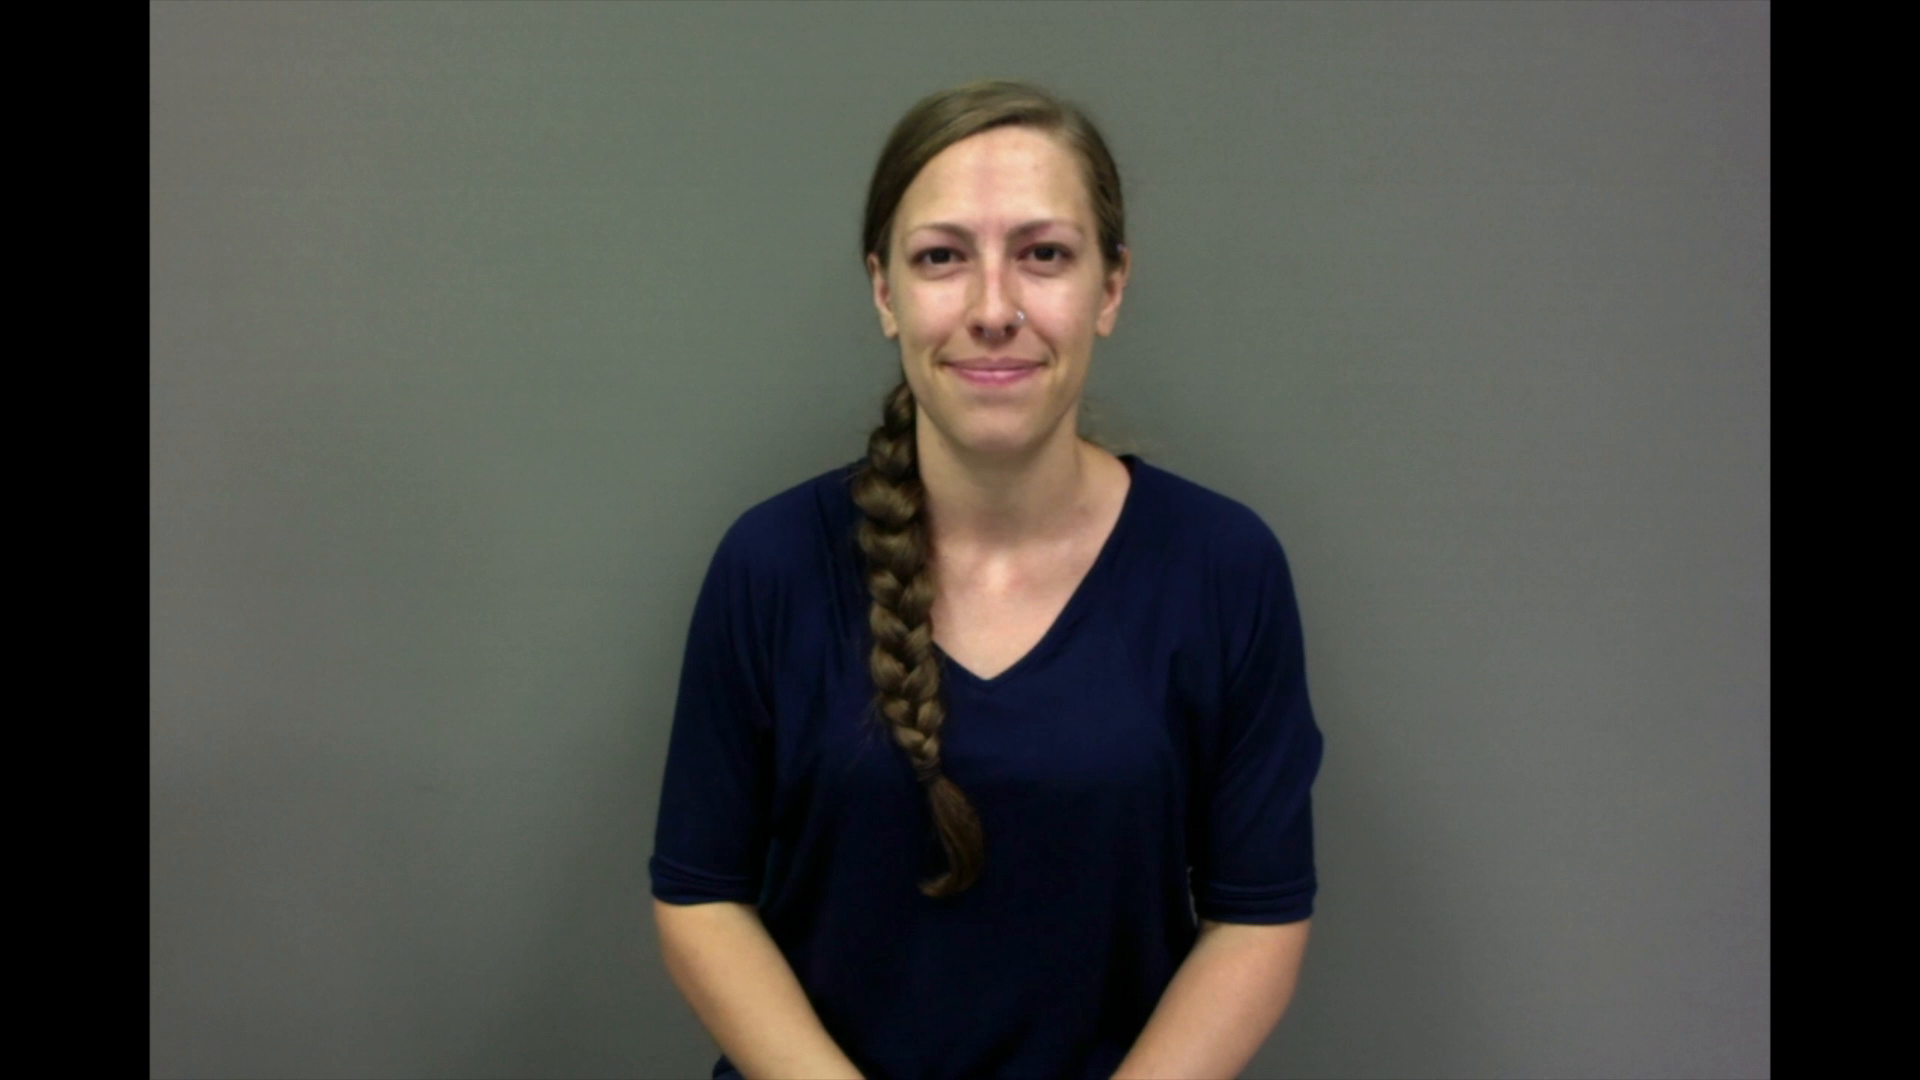

In [21]:
from IPython.display import display, clear_output
import time
from PIL import Image
for frame in vr:
    img = Image.fromarray(frame.asnumpy())
    clear_output(wait=True)
    display(img)
    time.sleep(1/vr.get_avg_fps())

In [14]:
#compares video with a description
def compare_vid_and_desc(video_path, description, system_content=None):
    # system_content = (
    #         "You are given description of an ASL gloss. Does it fully fit the given video? Focus on every detail like orientation of hands handshapes and movement. "
    #         # "You are an impartial evaluator. You must first describe the video in your own words before deciding whether the following text matches. Do not assume it is true."
    #         "Firstly think about how you would describe hand movements, handshape of both hands in the video. After that, explain in what ways the description might NOT fit the video. Then explain in what ways it might fit. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. "
    #     "Do not repeat the description if it matches and just answer. "    
    #     "The last word has to be YES or NO, nothing else."
    #         # "Give a YES or NO answer. And Explain why"
    #     # "You are a helpful asistant."
    #     )
    if system_content is None:
        system_content = (
                "You are given description of an ASL gloss. Does it fully fit the given video?"
                "Firstly describe hand movements, handshape of both hands in the video. Compare it with the given description. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. Be sceptical."
                "The last word has to be YES or NO, nothing else."
                # "Give a YES or NO answer. And Explain why"
            )
    # system_content = (
    #         "You are given description of an ASL gloss. Does it fully fit the given video?"
    #         # "Give a YES or NO answer. And Explain why"
    #         "Give a YES or NO answer."
    #     # "You are a helpful asistant."
    #     )
    
    prompt = description
    # prompt = description_from_internet
    
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": [
            {"type": "video", "video": f"file://{video_path}", "fps": fps},
            {"type": "text", "text": prompt},
            # {"type": "file", "file": open(glosses_csv, "rb")}
        ]}
    ]
    
    
    # Apply chat template and process vision inputs
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True) 
    
    if "fps" in video_kwargs and isinstance(video_kwargs["fps"], list):
        if len(video_kwargs["fps"]) == 1:
            video_kwargs["fps"] = video_kwargs["fps"][0]
        else:
            raise ValueError(f"Unexpected multiple fps values: {video_kwargs['fps']}")
    # print(len(video_inputs))
    # print(video_inputs[0].shape, video_tensor.dtype, video_tensor.device)
    # print(video_inputs[0].shape)
    # Prepare model inputs
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        **video_kwargs,  # Include video-specific kwargs
    )
    inputs = inputs.to("cuda")
    # Generate response
    generated_ids = model.generate(**inputs, max_new_tokens=512, do_sample=False, temperature=0.1)
    # generated_ids = model.generate(**inputs, max_new_tokens=2048, temperature=1)
    # print(processor.batch_decode(generated_ids, skip_special_tokens=True))
    # Trim prompt tokens and decode
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    # print(output_text)
    # print(output_text[0].split()[-1].replace("*", ""))
    
    # return output_text[0] if output_text else ""
    return output_text[0].split()[-1].replace("*", "").replace(".", "") if output_text else ""
# compare_vid_and_desc(video_path, video_description)

In [12]:
# Gives textual description without influence of the description it is compared to
def describe_video_gloss(video_path):
    system_content = (
            # "You are given a video of an ASL gloss."
            # "What handshape does the gloss in the video have?"
        # "Do not make assumptions of what gloss "
            "You are given a video of person moving their hands in a specific way."
            
            "Describe hand movements, handshape of both hands in the video, where and how do hands touch."
        "Do not describe properties of the person like clothes they have or hair."
        "Give a brief description."
        # "You are a helpful asistant."
        )
    prompt = "Describe hand movements, handshape of both hands in the video, where and how do hands touch in this video"
    
    # system_content = (
    #     "You are a helpful asistant."
    #     )
    # prompt = "What handshape does the gloss have?"
    # prompt = "What gloss is this?"
    
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": [
            {"type": "video", "video": f"file://{video_path}", "fps": fps},
            {"type": "text", "text": prompt},
            # {"type": "file", "file": open(glosses_csv, "rb")}
        ]}
    ]
    
    
    # Apply chat template and process vision inputs
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True) 
    
    if "fps" in video_kwargs and isinstance(video_kwargs["fps"], list):
        if len(video_kwargs["fps"]) == 1:
            video_kwargs["fps"] = video_kwargs["fps"][0]
        else:
            raise ValueError(f"Unexpected multiple fps values: {video_kwargs['fps']}")
    # print(len(video_inputs))
    # print(video_inputs[0].shape, video_tensor.dtype, video_tensor.device)
    # print(video_inputs[0].shape)
    # Prepare model inputs
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
        **video_kwargs,  # Include video-specific kwargs
    )
    inputs = inputs.to("cuda")
    # Generate response
    generated_ids = model.generate(**inputs, max_new_tokens=512, do_sample=False, temperature=0.1)
    # generated_ids = model.generate(**inputs, max_new_tokens=2048, temperature=1)
    # print(processor.batch_decode(generated_ids, skip_special_tokens=True))
    # Trim prompt tokens and decode
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)
    # print(output_text[0].split()[-1].replace("*", ""))
    
    return output_text[0] if output_text else ""
    # return output_text[0].split()[-1].replace("*", "") if output_text else ""
# video_description = describe_video_gloss(video_path)
# video_description = describe_video_gloss('/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/train/0/07068.mp4')


KeyboardInterrupt



In [17]:
video_path

'/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val/0/70212.mp4'

In [50]:
# Compares ground truth description with video description
def compare_txt_descriptions(description1, description2):
    system_content = (
            "You are given two descriptions of an ASL gloss. Are they describing the same gloss? They way of describing will be different, but do they describe the same reality?"
            "Compare these descriptions. Then, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO."
            # "Compare these descriptions and decide if they are describing the same gloss."
            # "Give YES or NO answers."
        )
    prompt = "Description 1: " + description1 + "\nDescription 2: " + description2
    
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": [
            # {"type": "video", "video": f"file://{video_path}", "fps": fps},
            {"type": "text", "text": prompt},
            # {"type": "file", "file": open(glosses_csv, "rb")}
        ]}
    ]
    
    
    # Apply chat template and process vision inputs
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = processor(
        text=[text],
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    # Generate response
    generated_ids = model.generate(**inputs, max_new_tokens=512, do_sample=False, temperature=0.1)
    # generated_ids = model.generate(**inputs, max_new_tokens=2048, temperature=1)
    # print(processor.batch_decode(generated_ids, skip_special_tokens=True))
    # Trim prompt tokens and decode
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)
    # print(output_text[0].split()[-1].replace("*", ""))
    
    return output_text[0] if output_text else ""
    # return output_text[0].split()[-1].replace("*", "") if output_text else ""

# print('description from model (how llm thinks it looks) vs internet description:')
# answer = compare_txt_descriptions(description, description_from_internet) #description from model vs internet description
# print('\ndescription of percieved video vs internet description:')
# answer = compare_txt_descriptions(video_description, description_from_internet)
# print('\ndescription of percieved video vs description from model (how llm thinks it looks):')
# answer = compare_txt_descriptions(video_description, description)

['Let me first describe the video based on the two descriptions provided.\n\n**Description 1** describes the ASL sign for **"BOOK"** as follows:\n- Both hands are in the **"A" handshape** (thumb and index finger forming a triangle, other fingers curled).\n- The dominant hand (usually right) starts near the chest, slightly in front of the non-dominant hand.\n- The dominant hand moves forward and slightly downward, as if placing a book on a surface.\n- The dominant hand "touches" or "rests" on the non-dominant hand, which remains relatively still.\n- The palms face downward or slightly inward.\n- The movement simulates placing or holding a book, with the "A" handshape representing the book\'s shape.\n\nThis is a **standard ASL sign for "BOOK"**, where the hands form the "A" shape (like a book\'s cover), and the dominant hand moves to rest on the non-dominant hand, mimicking placing a book down.\n\n**Description 2** says:\n- Place your **flat palms together**, little fingers touching.\n- 

In [8]:
import json
with open("internet_wlasl300_descriptions.json") as f:
    wlasl300_descriptions = json.load(f)

In [ ]:
# gloss = 'book'
# fps = 16
# tp = 0
# fp = 0
# fn = 0
# tn = 0
# #more sceptical
# system_content = (
#             "You are given description of an ASL gloss. Does it fully fit the given video? Focus on every detail like orientation of hands handshapes and movement. "
#             "Firstly think about how you would describe hand movements, handshape of both hands in the video. After that, explain in what ways the description might NOT fit the video. Then explain in what ways it might fit. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. "
#         "Do not repeat the description if it matches and just answer. "    
#         "The last word has to be YES or NO, nothing else."
#         )
# # #less sceptical
# # system_content = (
# #             "You are given description of an ASL gloss. Does it fully fit the given video? Focus on every detail like orientation of hands handshapes and movement. "
# #             "Firstly describe hand movements, handshape of both hands in the video. Compare it with the given description. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. "
# #             "The last word has to be YES or NO, nothing else."
# #             # "Give a YES or NO answer. And Explain why"
# #         )

# exceptions = []
# description = description_from_internet #qwens_text_description #description_from_internet #video_description
# for i, video_info in enumerate(gloss_videos):
#     answer = compare_vid_and_desc(video_info['video_path'], description, system_content)
#     video_gloss = video_info['ground_truth_gloss']
#     print(str(i)+video_gloss+answer )
#     if video_gloss == gloss and answer == "YES":
#         tp += 1
#     elif video_gloss != gloss and answer == "YES":
#         fp += 1
#     elif video_gloss == gloss and answer == "NO":
#         fn += 1
#     elif video_gloss != gloss and answer == "NO":
#         tn += 1
#     else:
#         exceptions.append(video_gloss + ": " + answer)
# print(tp)
# print(fn)
# print(fp)
# print(tn)
# for i, video_info in enumerate(other_gloss_videos):
#     answer = compare_vid_and_desc(video_info['video_path'], description, system_content)
#     video_gloss = video_info['ground_truth_gloss']
#     print(str(i)+video_gloss+answer )
#     if video_gloss == gloss and answer == "YES":
#         tp += 1
#     elif video_gloss != gloss and answer == "YES":
#         fp += 1
#     elif video_gloss == gloss and answer == "NO":
#         fn += 1
#     elif video_gloss != gloss and answer == "NO":
#         tn += 1
#     else:
#         exceptions.append(video_gloss + ": " + answer)
# print(tp)
# print(fn)
# print(fp)
# print(tn)

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = "output"
# with open(os.path.join(output_dir, f"{gloss}_YesNo_{timestamp}.log"), "a") as f:
#     f.write(model_name + "\n")
#     f.write(system_content + "\n")
#     f.write(gloss + "\n")
#     f.write(description + "\n")
#     f.write("true positive: " + str(tp) + "\n")
#     f.write("false negative: " + str(fn) + "\n")
#     f.write("false positive: " + str(fp) + "\n")
#     f.write("true negative: " + str(tn) + "\n")
#     f.write("number of exceptions = "  + str(len(exceptions)) + "\n")
#     for exception in exceptions:
#         f.write(exception + "\n")
    

In [19]:
video_info

{'video_path': '/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/train/140/04709.mp4',
 'ground_truth_gloss': 'bad',
 'gloss_id': 140,
 'video_id': '04709',
 'fps': 25}

In [22]:
# try:
#     answer = compare_vid_and_desc(video_info['video_path'], description, system_content)
# except Exception as e:
#     answer = e

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x6780f600] stream 1, offset 0x3b468: partial file
video_reader_backend decord error, use torchvision as default, msg: [23:02:01] /github/workspace/src/video/video_reader.cc:486: Error: av_read_frame failed with 1094995529
Invalid NAL unit size (745 > 472).
Error splitting the input into NAL units.


In [ ]:
# Configuration
# --- Set seeds ---
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


fps = 16

# #more sceptical
# system_content = (
#             "You are given description of an ASL gloss. Does it fully fit the given video? Focus on every detail like orientation of hands handshapes and movement. "
#             "Firstly think about how you would describe hand movements, handshape of both hands in the video. After that, explain in what ways the description might NOT fit the video. Then explain in what ways it might fit. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. "
#         "Do not repeat the description if it matches and just answer. "    
#         "The last word has to be YES or NO, nothing else."
#         )
#less sceptical
system_content = (
            "You are given description of an ASL gloss. Does it fully fit the given video? Focus on every detail like orientation of hands handshapes and movement. "
            "Firstly describe hand movements, handshape of both hands in the video. Compare it with the given description. Lastly, give a YES or NO answer. If everything fits, say YES. If there is something that does not fit, say NO. "
            "The last word has to be YES or NO, nothing else."
            # "Give a YES or NO answer. And Explain why"
        )
all_tp = 0
all_fp = 0
all_fn = 0
all_tn = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
with open(os.path.join(output_dir, f"glosses_YesNo_{timestamp}.log"), "a") as f:
    f.write(model_name + "\n")
    f.write(system_content + "\n")
    for i, gloss in enumerate(wlasl300_descriptions):
        print(gloss)
        gloss_videos = [v for v in val_videos if v['ground_truth_gloss'] == gloss] + [v for v in train_videos if v['ground_truth_gloss'] == gloss]
        videos = [v for v in val_videos if v['ground_truth_gloss'] != gloss]
        samples = random.sample(range(len(videos)), len(gloss_videos))
        other_gloss_videos = [videos[i] for i in samples]
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        exceptions = []
        description = wlasl300_descriptions[gloss] #qwens_text_description #description_from_internet #video_description
        for i, video_info in enumerate(gloss_videos):
            try:
                answer = compare_vid_and_desc(video_info['video_path'], description, system_content)
            except Exception as e:
                answer = e
            video_gloss = video_info['ground_truth_gloss']
            # print(str(i)+video_gloss+answer )
            if video_gloss == gloss and answer == "YES":
                tp += 1
            elif video_gloss != gloss and answer == "YES":
                fp += 1
            elif video_gloss == gloss and answer == "NO":
                fn += 1
            elif video_gloss != gloss and answer == "NO":
                tn += 1
            else:
                exceptions.append(video_gloss + ": " + str(answer))
        # print(tp)
        # print(fn)
        # print(fp)
        # print(tn)
        for i, video_info in enumerate(other_gloss_videos):
            try:
                answer = compare_vid_and_desc(video_info['video_path'], description, system_content)
            except Exception as e:
                answer = e
            video_gloss = video_info['ground_truth_gloss']
            # print(str(i)+video_gloss+answer )
            if video_gloss == gloss and answer == "YES":
                tp += 1
            elif video_gloss != gloss and answer == "YES":
                fp += 1
            elif video_gloss == gloss and answer == "NO":
                fn += 1
            elif video_gloss != gloss and answer == "NO":
                tn += 1
            else:
                exceptions.append(video_gloss + ": " + str(answer))
        print(tp)
        print(fn)
        print(fp)
        print(tn)
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        output_dir = "output"
        
        f.write(gloss + "\n")
        f.write(description + "\n")
        f.write("true positive: " + str(tp) + "\n")
        f.write("false negative: " + str(fn) + "\n")
        f.write("false positive: " + str(fp) + "\n")
        f.write("true negative: " + str(tn) + "\n")
        f1 = 2*tp/(2*tp+fp+fn)
        f.write("f1: " + str(f1) + "\n")
        f.write("number of exceptions = "  + str(len(exceptions)) + "\n")
        for exception in exceptions:
            f.write(exception + "\n")
        all_tp += tp
        all_fp += fp
        all_fn += fn
        all_tn += tn
    f.write("all glosses" + "\n")
    f.write("true positive: " + str(all_tp) + "\n")
    f.write("false negative: " + str(all_fn) + "\n")
    f.write("false positive: " + str(all_fp) + "\n")
    f.write("true negative: " + str(all_tn) + "\n")
    all_f1 = 2*all_tp/(2*all_tp+all_fp+all_fn)
    f.write("f1: " + str(all_f1) + "\n")
    

In [ ]:
# gloss = 'book'
# tp = 0
# fp = 0
# fn = 0
# tn = 0
# exceptions = []
# for i, video_info in enumerate(val_videos):
#     answer = compare_vid_and_desc(video_info['video_path'], video_description)
#     video_gloss = video_info['ground_truth_gloss']
#     print(str(i)+video_gloss+answer )
#     if video_gloss == gloss and answer == "YES":
#         tp += 1
#     if video_gloss != gloss and answer == "YES":
#         fp += 1
#     if video_gloss == gloss and answer == "NO":
#         fn += 1
#     if video_gloss != gloss and answer == "NO":
#         tn += 1
#     else:
#         exceptions.append(answer)

In [13]:
with open("book_YesNo5_description_from_qwen_first_explain_why_not.txt", "a") as f:
    f.write(gloss + "\n")
    f.write("true positive: " + str(tp) + "\n")
    f.write("false positive: " + str(fp) + "\n")
    f.write("false negative: " + str(fn) + "\n")
    f.write("true negative: " + str(tn))

In [11]:
# possibilities = ["true positive: ", "false negative: ", "false positive: ", "true negative: "]
# possibilities_cout = [0, 0, 0, 0]
# with open("output/glosses_YesNo_20251106_011717.log", "r")  as file:
#     for line in file:
#         if "all glosses" in line:
#             break
#         for i, possibility in enumerate(possibilities):
#             if possibility in line:
#                 # print(line.split("false positive: ")[1])
#                 possibilities_cout[i] += int(line.split(possibility)[1])
# possibilities_cout

[2290, 1046, 1020, 2321]